In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
train_path = '/content/sample_data/mnist_train_small.csv'
test_path = '/content/sample_data/mnist_test.csv'

In [3]:
class Dataset():
  def __init__(self, path, resize=1):
    self.path = path
    if resize == 1 or 2 or 4:
      self.resize = resize
      self.dim = dim = 28 // self.resize
    else:
      raise Exception('resize must be either 1, 2 or 4')
    self.samples = self.get_samples()

  def get_samples(self):
    samples = []
    data = pd.read_csv(self.path).to_numpy()
    if self.resize > 1:
      bs = len(data)
      y = data[:,0]
      X = data[:,1:].reshape((bs,28,28))
      A = np.zeros((self.dim,28))
      for i in range(self.dim):
        for j in range(self.resize):
          A[i][i*self.resize + j] = 1
      X = A @ X @ A.T
      X = (X // self.resize).astype(int)
      X = X.reshape((bs, self.dim ** 2))
      data = np.concatenate((np.expand_dims(y, axis=1),X), axis=1)
    
    for i in range(data.shape[0]):
      y = np.zeros(10)
      y[data[i][0]] = 1
      x = data[i][1:] / 255
      samples.append((x,y))
    return samples
  
  def __len__(self):
    return len(self.samples)
  
  def __getitem__(self, idx):
    return self.samples[idx]
  
  def view_sample(self, d=3):
    fig = plt.figure(figsize=(5,5))
    rows,cols = d,d
    for i in range(1,rows*cols + 1):
      idx = np.random.randint(len(self))
      x,y = self[idx]
      label = np.argmax(y)
      img = np.reshape(x,(self.dim,self.dim))
      fig.add_subplot(rows,cols,i)
      plt.axis('off')
      plt.title(label)
      plt.imshow(img,cmap="gray")
    plt.plot()

In [4]:
class Dataloader():
  def __init__(self,dataset,bs=64):
    self.dataset = dataset
    np.random.shuffle(self.dataset.samples)
    self.bs = bs
  
  def __len__(self):
    return len(self.dataset) // self.bs
  
  def __iter__(self):
    np.random.shuffle(self.dataset.samples)
    self.n = 0
    return self
  
  def __next__(self):
    if self.n < (len(self.dataset) // self.bs):
      x = np.expand_dims(self.dataset[self.n*self.bs][0],axis=0)
      y = np.expand_dims(self.dataset[self.n*self.bs][1],axis=0)
      for i in range(1, self.bs):
        x = np.concatenate((x,np.expand_dims(self.dataset[self.n*self.bs + i][0],axis=0)),axis=0)
        y = np.concatenate((y,np.expand_dims(self.dataset[self.n*self.bs + i][1],axis=0)),axis=0)
      self.n += 1
      return (x,y)
    else:
      raise StopIteration

In [5]:
class Model():

  def __init__(self, model_dimensions, lr=0.01, activation="Leaky ReLU", loss="Cross Entropy", tracking=False, use_batch_norm=True):
    
    self.dims = model_dimensions
    self.lr = lr
    self.layers = len(model_dimensions) - 1
    self.use_batch_norm = use_batch_norm
    self.tracking = tracking
    self.train_mode_on = True

    if loss == "Cross Entropy":
      self.loss = self.cross_entropy
    elif loss == "MSE":
      self.loss = self.MSE_loss
    else:
      raise Exception("Loss must be either 'Cross Entropy' or 'MSE'")
    
    if activation == "Sigmoid":
      self.activation = self.sigmoid
      self.activation_backwards = self.sigmoid_backwards
    elif activation == "Leaky ReLU":
      self.activation = self.Leaky_ReLU
      self.activation_backwards = self.Leaky_ReLU_backwards
    else:
      raise Exception("Activation function must be either 'Sigmoid' or 'Leaky ReLU'")
  
    self.parameters, self.activations, self.gradients, self.memory, self.bn = self.create_model()

  def train_mode(self):
    self.train_mode_on = True
  
  def test_mode(self):
    self.train_mode_on = False

  def initialise_weights(self, size):
    param = 2*np.random.random(size) - 1
    stdv = 1. / np.sqrt(size[0])
    return param * stdv

  def create_model(self):
    parameters, activations, gradients, memory, bn = {}, {}, {}, {}, {}
    gradients['L'] = None
    if self.tracking:
      memory['parameters'] = {}
      memory['gradients'] = {}
      memory['parameters']['min_max'] = [0,0]
      memory['gradients']['min_max'] = [0,0]
    for layer in range(1,len(self.dims)):
      input = self.dims[layer-1]
      output = self.dims[layer]
      parameters['W'+ str(layer)] = self.initialise_weights((input,output)) 
      parameters['B'+ str(layer)] = self.initialise_weights((output,)) 
      parameters['gamma' + str(layer)] = np.ones(output)
      parameters['beta' + str(layer)] = np.zeros(output)
      bn['mu' + str(layer)] = np.zeros(output)
      bn['var' + str(layer)] = np.ones(output)
      gradients['W'+ str(layer)] = np.zeros((input,output))
      gradients['B'+ str(layer)] = np.zeros(output)
      gradients['gamma' + str(layer)] = np.zeros(output)
      gradients['beta' + str(layer)] = np.zeros(output)

      if self.tracking:
        memory['parameters']['W'+ str(layer)] = np.expand_dims(parameters['W'+ str(layer)].copy(),axis=0)
        memory['parameters']['B'+ str(layer)] = np.expand_dims(parameters['B'+ str(layer)].copy(),axis=0)
        memory['gradients']['W'+ str(layer)] = np.zeros((1,input,output))
        memory['gradients']['B'+ str(layer)] = np.zeros((1,output))
    return parameters, activations, gradients, memory, bn
  
  def zero_grad(self):
    self.gradients['L'] = None
    for layer in range(1,self.layers+1):
      self.gradients['W'+ str(layer)] = self.gradients['W'+ str(layer)] * 0
      self.gradients['B'+ str(layer)] = self.gradients['B'+ str(layer)] * 0
      self.gradients['gamma' + str(layer)] = self.gradients['gamma' + str(layer)] * 0
      self.gradients['beta' + str(layer)] = self.gradients['beta' + str(layer)] * 0
  
  def sigmoid(self, x):
    return 1/(1+np.exp(-x))
  
  def sigmoid_backwards(self, dx, x):
    sig = self.sigmoid(x)
    return dx*sig*(1-sig)

  def Leaky_ReLU(self, x, alpha=0.01):
    return np.maximum(alpha*x,x)
  
  def Leaky_ReLU_backwards(self, dx, x, alpha=0.01):
    return dx*np.where(x<0,alpha,1)

  def batch_norm_forward(self, x, layer, eps=1e-5):
    N, D = x.shape
    gamma = self.parameters['gamma' + str(layer)]
    beta = self.parameters['beta' + str(layer)]
    if self.train_mode_on:
      mu = 1./N * np.sum(x, axis = 0)
      xmu = x - mu
      var = 1./N * np.sum(xmu ** 2, axis = 0)
      self.bn['mu' + str(layer)] = 0.9 * self.bn['mu' + str(layer)] + 0.1 * mu
      self.bn['var' + str(layer)] = 0.9 * self.bn['var' + str(layer)] + 0.1 * var
    else:
      mu = self.bn['mu' + str(layer)]
      xmu = x - mu
      var = self.bn['var' + str(layer)]
    sqrtvar = np.sqrt(var + eps)
    ivar = 1./sqrtvar
    xhat = xmu/sqrtvar
    gammax = gamma * xhat
    out = gammax + beta
    if self.train_mode_on:
      self.bn['cache' + str(layer)] = (xhat,xmu,ivar,sqrtvar,var,eps)
    return out

  def batch_norm_backward(self, dx, layer):
    (xhat,xmu,ivar,sqrtvar,var,eps) = self.bn['cache' + str(layer)]
    gamma = self.parameters['gamma' + str(layer)]
    N,D = dx.shape
    self.gradients['gamma' + str(layer)] += np.sum(dx*xhat, axis=0)
    self.gradients['beta' + str(layer)] += np.sum(dx, axis=0)
    dxhat = dx * gamma
    divar = np.sum(dxhat*xmu, axis=0)
    dxmu1 = dxhat * ivar
    dsqrtvar = -1. /(sqrtvar**2) * divar
    dvar = 0.5 * 1. /np.sqrt(var+eps) * dsqrtvar
    dsq = 1. /N * np.ones((N,D)) * dvar
    dxmu2 = 2 * xmu * dsq
    dx1 = (dxmu1 + dxmu2)
    dmu = -1 * np.sum(dxmu1+dxmu2, axis=0)
    dx2 = 1. /N * np.ones((N,D)) * dmu
    dx = dx1 + dx2
    return dx
  
  def MSE_loss(self, x, y):
    self.gradients['L'] = 2 * (x - y) / y.shape[0]
    return np.mean((x-y) ** 2)
  
  def cross_entropy(self, x, y):
    exps = np.exp(x)
    s = exps / np.sum(exps,axis=1,keepdims=True)
    loss = np.mean(np.sum( y * -np.log(s), axis=1))
    self.gradients['L'] = (s - y) / y.shape[0]
    return loss

  def forward(self, x):
    self.activations['A0'] = x
    for layer in range(1,self.layers+1):
      Z = self.activations['A'+ str(layer-1)] @ self.parameters['W'+ str(layer)] + self.parameters['B'+ str(layer)]
      self.activations['Z'+ str(layer)] = Z.copy()
      if self.use_batch_norm:
        Z = self.batch_norm_forward(Z, layer)
      self.activations['A'+ str(layer)] = self.activation(Z)
    return self.activations['A'+ str(self.layers)]
  
  def backward(self):
    dZ = self.gradients['L']
    for i in range(self.layers):
      layer = self.layers - i
      dA = self.activation_backwards(dZ,self.activations['Z'+ str(layer)])
      if self.use_batch_norm:
        dA = self.batch_norm_backward(dA, layer)
      self.gradients['B'+ str(layer)] += np.sum(dA,axis=0)
      self.gradients['W'+ str(layer)] += self.activations['A'+ str(layer-1)].T @ dA
      dZ = dA @ self.parameters['W'+ str(layer)].T
      if self.tracking:
        W = np.expand_dims(self.gradients['W'+ str(layer)].copy(),axis=0)
        B = np.expand_dims(self.gradients['B'+ str(layer)].copy(),axis=0)
        self.memory['gradients']['W'+ str(layer)] = np.concatenate((self.memory['gradients']['W'+ str(layer)],W),axis=0)
        self.memory['gradients']['B'+ str(layer)] = np.concatenate((self.memory['gradients']['B'+ str(layer)],B),axis=0)
    return dZ

  def step(self):
    for layer in range(1,self.layers+1):
      self.parameters['W'+ str(layer)] -= self.lr * self.gradients['W'+ str(layer)]
      self.parameters['B'+ str(layer)] -= self.lr * self.gradients['B'+ str(layer)]
      self.parameters['gamma'+ str(layer)] -= self.lr * self.gradients['gamma'+ str(layer)]
      self.parameters['beta'+ str(layer)] -= self.lr * self.gradients['beta'+ str(layer)]
      if self.tracking:
        W = np.expand_dims(self.parameters['W'+ str(layer)].copy(),axis=0)
        B = np.expand_dims(self.parameters['B'+ str(layer)].copy(),axis=0)
        self.memory['parameters']['W'+ str(layer)] = np.concatenate((self.memory['parameters']['W'+ str(layer)],W),axis=0)
        self.memory['parameters']['B'+ str(layer)] = np.concatenate((self.memory['parameters']['B'+ str(layer)],B),axis=0)
  
  def train_model(self, dataloader):
    losses = []
    self.train_mode()
    iterator = iter(dataloader)
    for batch in range(len(dataloader)):
      x,y = next(iterator)
      self.zero_grad()
      out = self.forward(x)
      loss = self.loss(out,y)
      self.backward()
      self.step()
      losses.append(loss)
    return losses
  
  def test_model(self, dataloader):
    count = 0
    self.test_mode()
    iterator = iter(dataloader)
    for batch in range(len(dataloader)):
      x,y = next(iterator)
      out = self.forward(x)
      count += np.where(np.argmax(out,axis=1) == np.argmax(y,axis=1), 1, 0).sum()
    accuracy = 100* count / (len(dataloader)*x.shape[0])
    return accuracy
  
  def train(self, train_dataloader, test_dataloader, epochs=1):
    losses = []
    for epoch in range(epochs):
      epoch_losses = self.train_model(train_dataloader)
      losses = np.concatenate((losses, epoch_losses))
      accuracy = self.test_model(test_dataloader)
      print(f'[Epoch {epoch+1}/{epochs}] Accuracy: {accuracy}%')
    plt.plot(losses)
  
  def normalise(self, frame, d_type, min_x, max_x):
    frame = (frame - min_x) / (max_x - min_x)
    mu = np.mean(frame)
    frame = frame - mu
    k = 0.1
    normalised_frame = 255 * (np.minimum(k,np.maximum(-k,frame)) + k) // (2*k)
    if normalised_frame.ndim == 1:
      normalised_frame = np.expand_dims(normalised_frame, axis=1)
    return normalised_frame.astype(int)
  
  def resize(self, frames, size):
    h = frames.shape[-2]
    w = frames.shape[-1]
    A = np.zeros((h,h*size))
    for i in range(h):
      for j in range(size):
        A[i][i*size + j] = 1
    B = np.zeros((w,w*size))
    for i in range(w):
      for j in range(size):
        B[i][i*size + j] = 1
    resized = A.T @ frames @ B
    return resized

  def create_gif(self, path, d_type="parameters", buffer=10, gap=5, sample_rate=10, resize=8):
    min_x, max_x = 0,0
    for layer in range(1,self.layers+1):
      min_x = min(min_x, np.min(self.memory[d_type]['W'+ str(layer)]), np.min(self.memory[d_type]['B'+ str(layer)]))
      max_x = max(max_x, np.max(self.memory[d_type]['W'+ str(layer)]), np.max(self.memory[d_type]['B'+ str(layer)]))
    if not(d_type == "parameters" or d_type == "gradients"):
      raise Exception("Data type must be either 'parameters' or 'gradients'")
    height = max(self.dims) + 2*buffer
    width = sum(self.dims[1:]) + 2*buffer + (3 + gap)*(len(self.dims) - 2)
    for i in range(len(self.memory[d_type]['W1'])):
      if i % sample_rate == 0:
        frame = np.full((height,width),255, dtype=np.uint8)
        for layer in range(1,self.layers+1):
          wx = buffer + sum(self.dims[1:layer]) + (layer - 1)*(3 + gap)
          wy = (height - self.dims[layer - 1]) // 2
          bx = wx + self.dims[layer] + 2
          by = (height - self.dims[layer]) // 2
          w = self.normalise(self.memory[d_type]['W'+ str(layer)][i], d_type, min_x, max_x)
          b = self.normalise(self.memory[d_type]['B'+ str(layer)][i], d_type, min_x, max_x)
          frame[wy:wy+self.dims[layer-1],wx:wx+self.dims[layer]] = w
          frame[by:by+self.dims[layer],bx:bx+1] = b
        if i == 0:
          frames = np.expand_dims(frame, axis=0)
        else:
          frames = np.concatenate((frames, np.expand_dims(frame, axis=0)), axis=0)
    frames = self.resize(frames,resize)
    images = [Image.fromarray(frame) for frame in frames]
    images[0].save(f'{path}/{d_type}.gif', format='gif', save_all=True, append_images=images[1:], duration=0.5, loop=0)

In [6]:
RESIZE = 1
input_dim = (28//RESIZE) ** 2
DIMS = [input_dim, 100, 50, 10]
BS = 64
LR = 0.01
BATCHNORM = True
ACTIVATION = "Leaky ReLU"           # 'Leaky ReLU' or 'Sigmoid'
LOSS_FUNC = "Cross Entropy"         # 'Cross Entropy' or 'MSE'
EPOCHS = 10

In [7]:
train_data = Dataset(train_path, resize=RESIZE)
test_data = Dataset(test_path, resize=RESIZE)
train_dataloader = Dataloader(train_data, BS)
test_dataloader = Dataloader(test_data, BS)

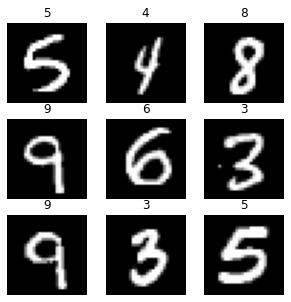

In [8]:
train_data.view_sample()

In [9]:
model = Model(DIMS, lr=LR, activation=ACTIVATION, loss=LOSS_FUNC, tracking=False, use_batch_norm=BATCHNORM)

[Epoch 1/10] Accuracy: 91.02564102564102%
[Epoch 2/10] Accuracy: 93.10897435897436%
[Epoch 3/10] Accuracy: 94.05048076923077%
[Epoch 4/10] Accuracy: 94.56129807692308%
[Epoch 5/10] Accuracy: 94.94190705128206%
[Epoch 6/10] Accuracy: 95.05208333333333%
[Epoch 7/10] Accuracy: 95.25240384615384%
[Epoch 8/10] Accuracy: 95.42267628205128%
[Epoch 9/10] Accuracy: 95.38261217948718%
[Epoch 10/10] Accuracy: 95.37259615384616%


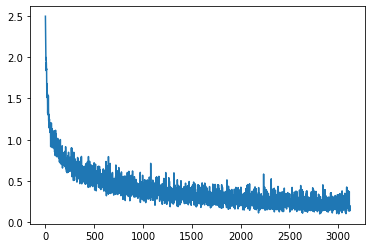

In [10]:
model.train(train_dataloader, test_dataloader, epochs=EPOCHS)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
gif_path = '/content/drive/MyDrive/Colab Notebooks/NumpyNN/Memory'  # directory to save gif

In [217]:
model.create_gif(gif_path, 'parameters')

In [218]:
model.create_gif(gif_path, 'gradients')

In [13]:
def view_image(input):
    img = np.reshape(input, (28,28))
    fig = plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(img,cmap="gray")
    plt.plot()

In [16]:
def generate_digit(digit):
  x = np.random.rand(BS,28*28)
  x.shape
  alpha = 0.01
  y = np.zeros((BS,10))
  y[:,digit] = 1
  for i in range(1,10000):
    out = model.forward(x)
    loss = model.loss(out,y)
    dx = model.backward()
    x -= alpha*dx
    if np.log10(i) % 1 == 0:
      alpha = int(alpha * 10)
  x_hat = np.mean(x,axis=0)
  return x_hat

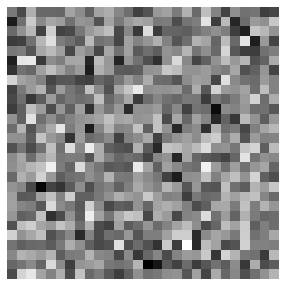

In [17]:
digit = generate_digit(2)
view_image(digit)